#                                 Projeto 2- Ciência dos Dados


##### Como os índices de suicídio são afetados por Índice de Desenvolvimento Humano, PIB ber Capita, sexo, geração, idade e país
Maria Victória Cavalieri e Laura Perim

## Introdução

Na atualidade, um dos assuntos mais comentados e discutidos é o suicídio. O intuito principal desse projeto é analisar uma base de dados que contém a variação da taxa de suicídios dentre diversos países, desde 10985

## 1- Importando e limpando os dados
Ness etapa, importamos a base de dados obtida no Kaggle, e a limpamos para podermos analisá-la com grau elevado de autonomia.

In [8]:
%matplotlib notebook
%matplotlib inline
%reset -f
from sklearn.model_selection import train_test_split
from scipy import stats
import pandas as pd
import numpy as np
from scipy.stats import norm, probplot
import statsmodels.api as sm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


In [9]:
 #Abrindo o documento e renomeando as colunas de alguns elementos das colunas
dados= pd.read_csv('suicide_.csv')
dados.rename(columns={'gdp_per_capita ($)':'gdp_capita'}, inplace=True)
dados.rename(columns={'HDI for year':'HDI'}, inplace=True)
dados.rename(columns={'suicides/100k pop' :'suicides_100k_pop'}, inplace=True)
dados.head()

,country,year,sex,age,suicides_no,population,suicides_100k_pop,country-year,HDI,gdp_for_year ($),gdp_capita,generation
0,Albania,1987,male,15-24 years,21,312900,6.71,Albania1987,NaN,"2,156,624,900",796,Generation X
1,Albania,1987,male,35-54 years,16,308000,5.19,Albania1987,NaN,"2,156,624,900",796,Silent
2,Albania,1987,female,15-24 years,14,289700,4.83,Albania1987,NaN,"2,156,624,900",796,Generation X
3,Albania,1987,male,75+ years,1,21800,4.59,Albania1987,NaN,"2,156,624,900",796,G.I. Generation
4,Albania,1987,male,25-34 years,9,274300,3.28,Albania1987,NaN,"2,156,624,900",796,Boomers


In [10]:
def regress(X,Y):
    '''
    X: coluna(s) do DataFrame que serão utilizadas como variável(is) preditoras/explicativas (independente(s))
    Y: coluna do DataFrame que será utilizada como variável resposta (dependente)
    '''
    X_cp = sm.add_constant(X)
    model = sm.OLS(Y,X_cp)
    results = model.fit()
    return results
df = dados[[ 'year', 'sex', 'age','suicides_100k_pop', 'population','HDI',
'gdp_capita','generation']].dropna()


In [11]:
df.describe()

,year,suicides_100k_pop,population,HDI,gdp_capita
count,8364.000000,8364.000000,8.364000e+03,8364.000000,8364.000000
mean,2005.348637,11.991936,1.852173e+06,0.776601,21074.371593
std,8.803020,17.361772,3.969754e+06,0.093367,22579.186968
min,1985.000000,0.000000,8.750000e+02,0.483000,313.000000
25%,2000.000000,1.040000,1.216425e+05,0.713000,4862.000000
50%,2010.000000,5.720000,4.722505e+05,0.779000,12584.000000
75%,2012.000000,15.442500,1.500290e+06,0.855000,30271.000000
max,2014.000000,187.060000,4.350934e+07,0.944000,126352.000000


## 2- Preparando os dados para análise
Aqui, tivemos que substituir palavras ( variáveis qualitativas) por binários, como 1= homem e 0=mulher. Isso será feito mais pra frente com os países e com as faixa etárias, que se tornarão variáveis denominadas "dummies". Basicamente elas também se tornam variáveis binárias, mas como há mais de uma categoria, só uma torna-se 1, enquanto todo o resto se torna 0 a cada linha.

In [12]:
#Separando os sexos masculinos e femininos para a análise de dados, e os nomeando com variáveis binárias para utilizar a função de regressão
df.loc[df.sex == 'male', 'sex'] = 1
df.loc[df.sex == 'female', 'sex'] = 0
df.sex = df.sex.astype('int')
df.head()

,year,sex,age,suicides_100k_pop,population,HDI,gdp_capita,generation
72,1995,1,25-34 years,5.58,232900,0.619,835,Generation X
73,1995,1,55-74 years,5.06,178000,0.619,835,Silent
74,1995,0,75+ years,4.90,40800,0.619,835,G.I. Generation
75,1995,0,15-24 years,4.59,283500,0.619,835,Generation X
76,1995,1,15-24 years,4.56,241200,0.619,835,Generation X


## 3- Análise descritiva
Vamos começar fazendo algumas análises básicas dos dados como correlação entre elas. A correlação é um índice que varia de -1 a 1 e indica o quanto uma variável depende da outra. Se a correlação for muito alta, isso pode atrapalhar na análise de regressão. 

                   suicides_100k_pop  population       HDI  gdp_capita
suicides_100k_pop           1.000000   -0.023197  0.074279   -0.002339
population                 -0.023197    1.000000  0.102943    0.073701
HDI                         0.074279    0.102943  1.000000    0.771228
gdp_capita                 -0.002339    0.073701  0.771228    1.000000


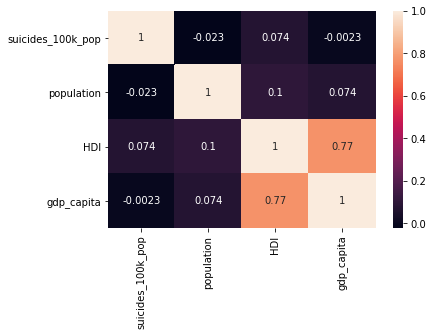

In [13]:
#Calculando a correlação entre anguns dados da tabela,  e calculando a média entre as faixas etárias 
df2= df[['suicides_100k_pop', 'population','HDI',
'gdp_capita']]
correlacao= df2.corr()
print(correlacao)
import seaborn

plt.figure()
seaborn.heatmap(df2.corr(), annot=True)
plt.show()

Apesar de algumas correlações serem razoavelmente altas, como HDI (Índice de desenvolvimento humano) e GDP ( PIB per capita), 
vamos considerar todas as variáveis como possíveis influentes em nossa análise. Definimos que se a correlção superasse 0,8, ela seria
desconsiderada da análise, mas não houve nenhum caso assim.

Agora, vamos analisar como a média da taxa de suicídios se distribui para cada faixa etária. Para isso, plotaremos um histograma
que combina essa média com cada idade representada.

### Analisando os dados por idade

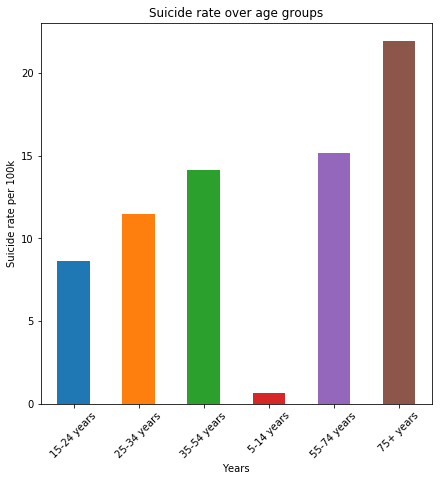

age
15-24 years     8.651736
25-34 years    11.467518
35-54 years    14.116133
5-14 years      0.628623
55-74 years    15.143006
75+ years      21.944598
Name: suicides_100k_pop, dtype: float64


sex
0     4.937198
1    19.046674
Name: suicides_100k_pop, dtype: float64

In [29]:

media_gender= df.suicides_100k_pop.groupby(by=df.age).mean()
plt.figure(figsize=(7,7))
media_gender.plot.bar(rot=45)
plt.xlabel("Years",fontsize=10)
plt.ylabel("Suicide rate per 100k")
plt.title('Suicide rate over age groups')
plt.show()

print(media_gender)
df.suicides_100k_pop.groupby(by=df.sex).mean()

In [ ]:
years= ["15-24 years","25-34 years","35-54 years", "5-14 years","55-74 years", "75+ years"]
plt.figure()
plt.pie(media_gender,labels=years,autopct='%1.1f%%')
plt.title("Suicide rates by age")

Podemos observar que a menor taxa se encontra entre crianças de 5-14 anos, e que a maior encontrasse na faixa de 75+ anos. Também podemos observar que as faixas de 35-54
e 55-74 anos são bem próximas.

### Analisando os dados por sexo

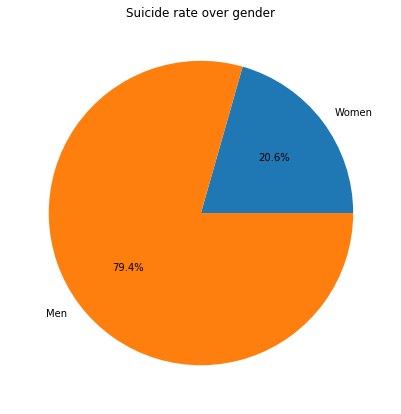

<bound method NDFrame.describe of sex
0     4.937198
1    19.046674
Name: suicides_100k_pop, dtype: float64>

In [15]:
media= df.suicides_100k_pop.groupby(by=df.sex).mean()
plt.figure(figsize=(7,7))
labels= ["Women","Men"]
plt.pie(media,labels=labels,autopct='%1.1f%%')
plt.title('Suicide rate over gender')
plt.show()
media.describe

Observa-se que o fator de sexo é um grande influenciador nas taxas de suicídio, uma vez que as mulheres possuem uma taxa consideravelmente menor em relação aos homens.

### Plotando um histograma para analisar a média por país
Agora vamos analisar como a taxa média de suicídios se distribui para cada país.

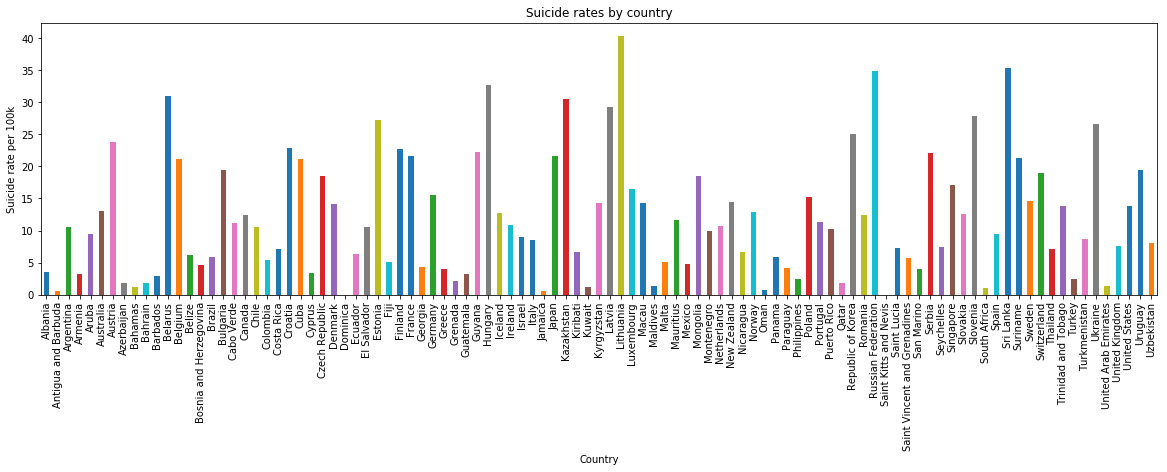

In [16]:
df_pais = dados[[ 'country','year', 'sex', 'age','suicides_100k_pop', 'population','HDI',
'gdp_capita','generation']]
mediaporpais=country_relevance= df_pais.suicides_100k_pop.groupby(by=df_pais.country).mean()
plt.figure(figsize=(20,5))
mediaporpais.plot.bar()
plt.xlabel('Country')
plt.ylabel("Suicide rate per 100k")
plt.title("Suicide rates by country")
plt.show()

### Análise dos dados por ano

Agora vamos analisar como a taxa de suicídios varia de acordo com o ano, desde 1985 até 2016:

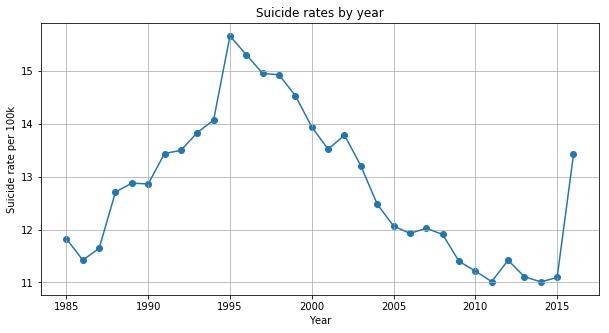

In [17]:
df_ano = dados[[ 'country','year', 'sex', 'age','suicides_100k_pop', 'population','HDI',
'gdp_capita','generation']]
mediaporano= df_ano.suicides_100k_pop.groupby(by=df_ano.year).mean()
plt.figure(figsize=(10,5))
plt.scatter(mediaporano.index,mediaporano)
plt.plot(mediaporano.index,mediaporano)
plt.xlabel('Year')
plt.ylabel("Suicide rate per 100k")
plt.title("Suicide rates by year")
plt.grid(True)
plt.show()

Pelo gráfico, observa-se que as taxas de suicídio tendem a crescer, de 1985 a 1995. Esse último ano possui alto índice de  crescimento, que dado a tendência do resto dos dados pode ser dito como anormal em comparação aos demais anos, podendo ser considerado um outliar. A tendência até 2002 é descrescente novamente. Nesse ano, há um pico, que é seguido por um decrescimento até 2016, quando há um segundo pico.

### Analisando os dados por PIB

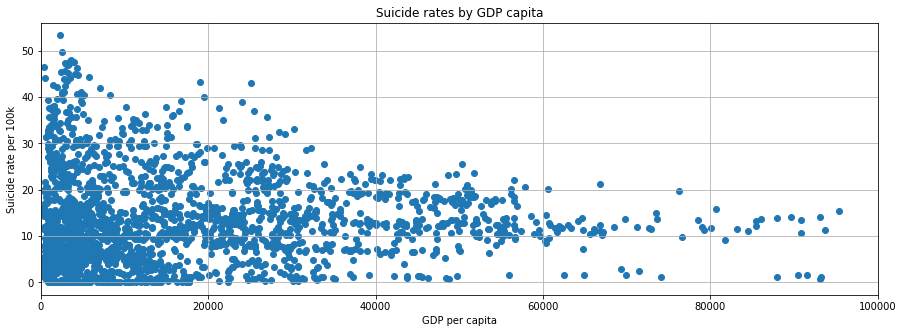

In [67]:
df_gdp = dados[[ 'country','year', 'sex', 'age','suicides_100k_pop', 'population','HDI',
'gdp_capita','generation']]
mediaporpib= df_ano.suicides_100k_pop.groupby(by=df_gdp.gdp_capita).mean()
plt.figure(figsize=(15,5))
plt.scatter(mediaporpib.index,mediaporpib)
plt.xlim(0,100000)
plt.xlabel('GDP per capita')
plt.ylabel("Suicide rate per 100k")
plt.title("Suicide rates by GDP capita")
plt.grid(True)
plt.show()

Como indicado no gráfico, há maior concentração de altos índices de suicídio á esquerda do gráfico, o que indica que a probabilidade de uma país com baixo PIB de ter um alto índice de suicídios é maior em comparação a países com maior PIB.

### Analisando os dados por Índice de Desenvolvimento Humano

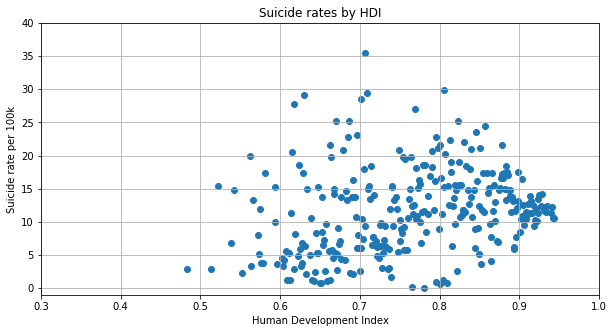

In [82]:
df_hdi = dados[[ 'country','year', 'sex', 'age','suicides_100k_pop', 'population','HDI',
'gdp_capita','generation']]
mediaporhdi= df_ano.suicides_100k_pop.groupby(by=df_hdi.HDI).mean()
plt.figure(figsize=(10,5))
plt.scatter(mediaporhdi.index,mediaporhdi)
plt.xlim(0.3,1)
plt.ylim(-1,40)
plt.xlabel('Human Development Index')
plt.ylabel("Suicide rate per 100k")
plt.title("Suicide rates by HDI")
plt.grid(True)
plt.show()

Podemos observar que não há uma relação clara entre o Índice de Desenvolvimento Humano e as taxas de suicídio, uma vez que os pontos formam uma nuvem distribuída. Apesar disso, é mais difícil encontrar índices mais elevados como mais de 20 em países aonde o Índice é supeior a 0,85, e os que possuem Índice superior a 0.9 não superam a faixa de 15.

## 4- Análise por Regressão Linear Múltipla

Vamos começar a analisar nosso modelo por meio de Regressão Linear. A Regressão Linear consiste em analisar como uma variável se comporta a medida que outra variável sofre alterações. Ela é frequentemente usada em análises metereológicas e na área de marketing, por exemplo, para prever o comportamento do tempo, de ações, entre outros. Nesse modelo, temos uma (ou mais, em nosso caso de Regressão Múltipla temos 7), variáveis dependentes, e nosso objetivo é analisar como estas afetam Y, a variável independente. As variáveis X, para essa análise consistem na idade (age), ano(year),população (population), Índice de desenvolvimento humano (HDI), PIB (gdp per capita), sexo (gender), e geração (generation). Já nossa variável independente (Y), será a taxa de suicídios por 100 mil habitantes. Em resumo, verificaremos qual a relação de nossas variáveis X e como elas afetam Y.


Para realizar essa tarefa, o modelo de Regressão faz uma média entre os pontos de Y, por meio do Método dos Mínimos Quadrados, que busca minimizar a distância entre os valores de Y o máximo possível, por meio da seguinte fórmula:



$$y_i=\beta_0+\beta_1x_i+\varepsilon_i$$

Onde:
1. $\beta_i$ são os coeficientes do modelo de regressão;
1. $\varepsilon_i$ representa os **erros aleatórios**. O erro aleatório tem média zero e variância (desconhecida) $\sigma^2$. Além disso, esses erros aleatórios correspondentes as diferentes observações são também considerados variáveis aleatórias não correlacionadas.

Os coeficientes são calculados por meio do Métodos dos Mínimos Quadrados, dado por:

$$\hat{\beta}_0=\bar{y}-\hat{\beta}_1\bar{x}$$

$$\hat{\beta}_1=\frac{S_{XY}}{S_{XX}}=\frac{\sum_{i=1}^n(x_i-\bar{x})(y_i-\bar{y})}{\sum_{i=1}^n(x_i-\bar{x})^2}$$

<div id="suposicoes"></div>

Como possuímos mais de um $\beta_i$ , utilizaremos o modelo de Regressão Linear Múltipla do Python, que calcula esses coeficientes por meio da função OLS, contida no começo deste notebook. 
Para isso, vamos primeiro dividir nossos dados em X, Y e treinamento e teste. Essa última etapa é importante para testarmos a eficácia de nosso modelo garantindo que ele não estará enviezado.

In [18]:
X = df[[ 'sex', 'year', 'population','HDI',
'gdp_capita']]
X = X.join(pd.get_dummies(df['age']))
X = X.join(pd.get_dummies(df['generation']))
Y = df['suicides_100k_pop']

X_train, X_test, y_train, y_test = train_test_split(
X, Y, test_size=0.33, random_state=42)
results = regress(X_train,y_train)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      suicides_100k_pop   R-squared:                       0.335
Model:                            OLS   Adj. R-squared:                  0.333
Method:                 Least Squares   F-statistic:                     187.4
Date:                Tue, 09 Jun 2020   Prob (F-statistic):               0.00
Time:                        10:31:44   Log-Likelihood:                -22733.
No. Observations:                5603   AIC:                         4.550e+04
Df Residuals:                    5587   BIC:                         4.560e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             351.3461     78.367      4.483      0.000     197.717     504.975
sex                14.0193      0.375     37.427      0.000      13.285      14.754
year               -0.2459      0.052     -4.703      0.000      -0.348      -0.143
population      -6.475e-08   4.87e-08     -1.330      0.184    -1.6e-07    3.07e-08
HDI                41.9307      3.271     12.820      0.000      35.519      48.343
gdp_capita         -0.0001   1.33e-05     -8.543      0.000      -0.000   -8.75e-05
15-24 years        55.0835     12.429      4.432      0.000      30.718      79.449
25-34 years        58.0441     12.652      4.588      0.000      33.240      82.848
35-54 years        61.2293     13.209      4.635      0.000      35.334      87.124
5-14 years         45.0859     11.967      3.767      0.000      21.626      68.546
55-74 years        62.9450     13.904      4.527      0.000      35.687      90.203
75+ years          68.9584     14.302      4.822      0.000      40.921      96.995
Boomers            57.1011     12.738      4.483      0.000      32.129      82.073
G.I. Generation    60.0247     11.425      5.254      0.000      37.627      82.423
Generation X       57.9557     13.384      4.330      0.000      31.718      84.193
Generation Z       61.4361     14.653      4.193      0.000      32.710      90.162
Millenials         58.7499     14.051      4.181      0.000      31.205      86.295
Silent             56.0786     12.236      4.583      0.000      32.092      80.065
==============================================================================
Omnibus:                     3126.243   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            35341.617
Skew:                           2.457   Prob(JB):                         0.00
Kurtosis:                      14.280   Cond. No.                     5.94e+22
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.99e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

A coluna P>t nos indica o quão relevante aquela variável é para a nossa variável Y independente. Nesse caso, considerando alpha=10%, todas tem relevância exceto a variável de população. 

In [32]:
X = df[[ 'sex', 'year','HDI',
'gdp_capita']]
X = X.join(pd.get_dummies(df['age']))
X = X.join(pd.get_dummies(df['generation']))
Y = df['suicides_100k_pop']

X_train, X_test, y_train, y_test = train_test_split(
X, Y, test_size=0.33, random_state=42)
results = regress(X_train,y_train)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      suicides_100k_pop   R-squared:                       0.335
Model:                            OLS   Adj. R-squared:                  0.333
Method:                 Least Squares   F-statistic:                     200.6
Date:                Tue, 09 Jun 2020   Prob (F-statistic):               0.00
Time:                        11:41:54   Log-Likelihood:                -22734.
No. Observations:                5603   AIC:                         4.550e+04
Df Residuals:                    5588   BIC:                         4.560e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             349.5897     78.361      4.461      0.000     195.972     503.207
sex                14.0244      0.375     37.440      0.000      13.290      14.759
year               -0.2447      0.052     -4.680      0.000      -0.347      -0.142
HDI                41.6010      3.262     12.755      0.000      35.207      47.995
gdp_capita         -0.0001   1.33e-05     -8.539      0.000      -0.000   -8.75e-05
15-24 years        54.7853     12.428      4.408      0.000      30.422      79.149
25-34 years        57.7550     12.651      4.565      0.000      32.953      82.557
35-54 years        60.8608     13.207      4.608      0.000      34.970      86.752
5-14 years         44.7783     11.966      3.742      0.000      21.321      68.236
55-74 years        62.6589     13.904      4.507      0.000      35.402      89.916
75+ years          68.7514     14.302      4.807      0.000      40.714      96.789
Boomers            56.7900     12.737      4.459      0.000      31.820      81.760
G.I. Generation    59.7220     11.424      5.228      0.000      37.327      82.117
Generation X       57.6607     13.383      4.309      0.000      31.425      83.896
Generation Z       61.1791     14.653      4.175      0.000      32.454      89.905
Millenials         58.4584     14.050      4.161      0.000      30.915      86.002
Silent             55.7794     12.234      4.559      0.000      31.795      79.763
==============================================================================
Omnibus:                     3132.930   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            35492.784
Skew:                           2.463   Prob(JB):                         0.00
Kurtosis:                      14.303   Cond. No.                     2.61e+20
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 7.64e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

Numa análise de Regressão múltipla, retiramos as variáveis que não importam ( ou seja, são menores que alpha), até que só as menores que alpha sejam os parâmetros considerados. No entanto, a única que desconsideramos foi a de população nesse caso.

Como podemos observar, os índices que indicam a probabilidade dos resíudos seguirem uma normal (Prob JB e Prob Omnibus), são inferiores a alfa, o que provavelmente significa que os erros são distantes de uma normal. Com isso, concluímos que o modelo de Regressão Linear pode apresentar algumas imprecisões devido a isso, já que ele assume que os erros seguem uma distribuição próxima a uma Normal.
A função "results.resid" calcula os erros e nos indica seu comportamento, seguindo a seguinte fórmula:
$$e_i=y_i-\hat{y_i}=y_i-(\hat{\beta}_0+\hat{\beta}_1x_i)$$



Para ter certeza, vamos plotar um gráficos dos resíduos e compará-los com o comportamento normal:

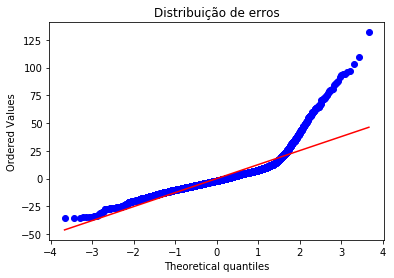

In [34]:

plt.figure()
erros=results.resid
stats.probplot(erros,dist='norm',plot=plt)
plt.title("Distribuição de erros")
plt.show()

O gráfico acima confirma que os erros não seguem um comportamento normal, principalmente conforme aumentam. Isso significa que nosso modelo provavelmente não predirá de forma precisa o Índice de Suicídios. Vamos confirmar nossa hipótese usando nossa base de testes:

In [20]:
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor 
results_teste = regress(X_test,y_test)
y_pred= results_teste.predict(sm.add_constant(X_test))
erro=mean_squared_error(y_test,y_pred)
print(erro)


208.75099730214632


Vamos comparar nosso erro com o erro se considerarmos também a base de dados que utilizamos para treinar nosso modelo:

In [21]:
y_pred= results_teste.predict(sm.add_constant(X_train))
erro=mean_squared_error(y_train,y_pred)
print(erro)

196.60646626886785


O índice de erros diminuiu, mas ainda existe, Algumas explicações para isso podem ser relacionadas ás Inferências que o modelo de Regressão faz.  Dentre elas, estão os erros em distribuição Normal, que como indicado previamente não é uma verdade para esse conjunto específico de dados, se analisarmos o gráfico de Distribuição de erros. Além disso, ele considera que so erros são independentes entre si, o que pode não ser uma verdade também. Outra hipótese é a de que a Correlação entre os índices de GDP e HDI, que já analisamos previamente, pode afetar o modelo, dada que ela quase supera nosso limite, que era 0.8. 

Se observamos a distribuição da Taxa de suicídios, veremos que 75% está no valor até 15,aproximadamente. Porém, o máximo é 187, o que indica que há valores que descolam muito da maioria (denominados outliars), e que podem estar contribuindo para que o modelo não funcione da forma ideal. Vamos descobrir quem são esses outliars e buscar fazer a regressão apenas com 99% dos valores obtidos, ou seja, taxas correspondentes a 85 ou menos:

In [22]:

df3= dados[[ 'year', 'sex', 'age','suicides_100k_pop', 'population','HDI',
'gdp_capita','generation','country-year']].dropna()
i=0
#printando os países outliars em seus respectivos anos
for i in range(len(df3)):
    if df3.iloc[i]['suicides_100k_pop']>85:
        print(df3.iloc[i]['country-year'])
df3.head()
faixa= np.arange(0,1,0.01)
Y.quantile(faixa)

Austria1985
Austria1990
Austria1995
Austria2000
Austria2013
Belarus2000
Belarus2000
Belgium1985
Belgium1990
Bulgaria1985
Bulgaria1990
Bulgaria1995
Bulgaria2000
Croatia1995
Croatia2000
Croatia2005
Croatia2010
Cuba1995
Cuba2000
Cuba2011
Cuba2012
Czech Republic1990
Czech Republic1995
Estonia1995
Estonia1995
Estonia1995
Estonia2000
Finland1990
France1985
France1990
France1995
France2000
Germany1990
Guyana2010
Guyana2010
Hungary1995
Hungary2000
Hungary2005
Hungary2010
Hungary2012
Hungary2013
Kazakhstan1995
Kazakhstan1995
Kazakhstan1995
Latvia1995
Latvia1995
Latvia1995
Latvia2000
Latvia2000
Latvia2000
Lithuania1995
Lithuania1995
Lithuania1995
Lithuania2000
Lithuania2000
Lithuania2000
Lithuania2005
Lithuania2005
Lithuania2013
Lithuania2014
Luxembourg1985
Luxembourg2000
Serbia2000
Serbia2005
Serbia2010
Serbia2011
Serbia2012
Singapore1995
Slovenia1995
Slovenia2000
Slovenia2005
Slovenia2010
Slovenia2011
Slovenia2012
Slovenia2013
Slovenia2014
Sri Lanka1985
Sri Lanka1985
Sri Lanka2000
Suriname2010

0.00     0.0000
0.01     0.0000
0.02     0.0000
0.03     0.0000
0.04     0.0000
0.05     0.0000
0.06     0.0000
0.07     0.0000
0.08     0.0000
0.09     0.0000
0.10     0.0000
0.11     0.0000
0.12     0.0000
0.13     0.0000
0.14     0.0600
0.15     0.1845
0.16     0.2600
0.17     0.3200
0.18     0.3800
0.19     0.4400
0.20     0.5200
0.21     0.6400
0.22     0.7500
0.23     0.8500
0.24     0.9500
0.25     1.0400
0.26     1.1600
0.27     1.2900
0.28     1.4100
0.29     1.5600
         ...   
0.70    12.7500
0.71    13.2500
0.72    13.8000
0.73    14.3700
0.74    14.9062
0.75    15.4425
0.76    16.1500
0.77    17.0151
0.78    17.6714
0.79    18.4800
0.80    19.3940
0.81    20.2503
0.82    21.1700
0.83    22.1258
0.84    23.1200
0.85    24.0610
0.86    25.2200
0.87    26.2581
0.88    27.4900
0.89    29.5007
0.90    31.3470
0.91    33.4533
0.92    35.6092
0.93    38.3859
0.94    41.1664
0.95    45.7325
0.96    51.8044
0.97    58.4631
0.98    70.8018
0.99    85.5974
Name: suicides_100k_pop,

Podemos observar que a Lituânia e outros países nórdicos, como a Estônia e a Eslovênia por exemplo, possuem uma ocorrência mais frequente nesse grupo que se destaca do resto dos dados, ou seja, possuem índices muito mais altos que o comum.  Há diversos motivos apontados por especialistas que explicam isso, mas o principal decorre da ausência de sol na maior parte do ano nesses lugares, o que aumenta a tendência a depressão e, consequentemente, ao suicídio. Outros fatores que também podem ser considerados como problemas socio-econômicos, mudanças radicais no sistema dado ao fim de União Soviética, entre outros.

In [23]:
df4= df[df['suicides_100k_pop']<85].copy()
X4 = df4[[ 'sex', 'year', 'population','HDI',
'gdp_capita']]
X4 = X4.join(pd.get_dummies(df['age']))
X4 = X4.join(pd.get_dummies(df['generation']))
Y4 = df4['suicides_100k_pop']
X4_train, X4_test, y4_train, y4_test = train_test_split(
X4, Y4, test_size=0.33, random_state=42)
results4 = regress(X4_train,y4_train)
results4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      suicides_100k_pop   R-squared:                       0.356
Model:                            OLS   Adj. R-squared:                  0.354
Method:                 Least Squares   F-statistic:                     203.9
Date:                Tue, 09 Jun 2020   Prob (F-statistic):               0.00
Time:                        10:31:49   Log-Likelihood:                -21508.
No. Observations:                5544   AIC:                         4.305e+04
Df Residuals:                    5528   BIC:                         4.315e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             234.3388     66.381      3.530      0.000     104.206     364.472
sex                12.5764      0.315     39.895      0.000      11.958      13.194
year               -0.1682      0.044     -3.798      0.000      -0.255      -0.081
population      -2.355e-08   4.02e-08     -0.586      0.558   -1.02e-07    5.52e-08
HDI                41.2634      2.735     15.085      0.000      35.901      46.626
gdp_capita      -9.479e-05    1.1e-05     -8.626      0.000      -0.000   -7.32e-05
15-24 years        36.9045     10.527      3.506      0.000      16.268      57.541
25-34 years        39.6857     10.713      3.704      0.000      18.684      60.688
35-54 years        41.3886     11.190      3.699      0.000      19.451      63.326
5-14 years         28.2381     10.135      2.786      0.005       8.369      48.107
55-74 years        42.0541     11.782      3.569      0.000      18.956      65.152
75+ years          46.0679     12.114      3.803      0.000      22.319      69.817
Boomers            39.1770     10.784      3.633      0.000      18.036      60.318
G.I. Generation    39.9628      9.677      4.130      0.000      20.992      58.934
Generation X       38.7124     11.334      3.416      0.001      16.494      60.931
Generation Z       39.5592     12.416      3.186      0.001      15.218      63.900
Millenials         38.3361     11.901      3.221      0.001      15.006      61.666
Silent             38.5913     10.369      3.722      0.000      18.264      58.919
==============================================================================
Omnibus:                     2144.625   Durbin-Watson:                   2.020
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10828.145
Skew:                           1.805   Prob(JB):                         0.00
Kurtosis:                       8.817   Cond. No.                     5.89e+22
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.16e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [24]:
y_pred4= results4.predict(sm.add_constant(X4_test))
erro4=mean_squared_error(y4_test,y_pred4)
print(erro4)

133.47190063413967


Podemos observar que nosso erro caiu consideravelmente, de 208 para 133 ( se compararmos o erro relativo aos testes, ou seja sem o viés dado pelos dados de treinamento). Podemos concluir portanto que os pontos muito acima do esperado ( que representavam apenas 1% de nossos dados) estavam fazendo com que nosso modelo fosse mais impreciso. Ao excluírmos estes pontos, podemos analisar de forma mais precisa e ponderada nossos dados.

## 5- Modelo de Regressão Random Forest

Agora vamos utilizar outro modelo de Regressão denominado Random Forest, e ver como o erro deste se compara ao anterior. O método interpreta de uma maneira aleatória, vários modelos diferentes ,estabelecendo  regras de tomadas de decisões, buscando melhores condições para a análise. Geralmente, o que se busca fazer é encontrar a variável mais relevante para nossa saída Y, e com isso os valores que nos dão o conjunto populacional com menos diferenças, ou seja, mais homogêneo possível. A vantagem do Random Forest é que ele tende a evitar o overfitting, ou seja, quando há muitos dados a serem considerados, nosso modelo poderia perder a capacidade de generalização.

O que o Random Forest faz para evitar isso é formar conjuntos menores de  features (característica aleatórias para avaliar), selecionar os que melhor representam um "Nó raíz", ou seja, um nó que depois será divido em em outros, como se fossem ramos, por isso o nome Forest. Depoi o algorítimo cria os nós filhos, ou seja, os que são derivados do nó raíz, e repete isso sucessivamente. Ao final, o modelo compara as votações de cada mini ramo, e a decisão mais votada é a tomada de decisão.

Já o parâmetro "random_state", apenas garante que todas as vezes que rodarmos a regressão com esse mesmo número, iremos obter os mesmos resultados, já que este é um modelo aleatório e poderia fornecer diferentes resultados cada vez que o rodássemos.

In [25]:
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor 
  
 # criando o objeto da regressão
regressor = RandomForestRegressor(n_estimators = 200, random_state = 0) 
# fazendo o fit da regressão com nosso x e y de treinamento
regressor.fit(X_train, y_train)   
y_pred= regressor.predict(X_test)
erro=mean_squared_error(y_test,y_pred)
print(erro)

89.57007397661356


Podemos observar que esse erro é bem menor que o anterior dado pela regressão linear, o que significa que ele é mais eficaz nesse caso. Vale ressaltar que o parâmetro "n_estimator" corresponde ao números de "árvores", ou seja, quanto maior for mais precisa tende a ser a análise, já que levaremos mais variáveis em conta. No entanto, há um limite em que o erro se mantém muito parecido a partir de certo número, nesse caso, um parâmetro maior que 200 mantinha o erro de 89 e toma um tempo maior para ser estimado.

Vamos comparar nosso erro com o erro se considerarmos também a base de dados que utilizamos para treinar nosso modelo:

In [26]:

y_pred= regressor.predict(X_train)
erro=mean_squared_error(y_train,y_pred)
print(erro)

12.574727275978493


O erro diminui bastante ao fazermos isso, uma vez que a base inclui também os dados utilizados para ensinar o modelo a avaliar as variáveis

Agora vamos fazer o que fizemos com a regressão linear no que se refere a excluir os dados que saem muito do esperado, os outliars. O que esperamos fazer com isso é aumentar a precisão de nosso modelo para que ele preveja com menos erros nosso Y:

In [27]:
regressor.fit(X4_train, y4_train)   
y5_pred= regressor.predict(X4_test)
erro_semoutliar=mean_squared_error(y4_test,y5_pred)
print(erro_semoutliar)

54.138296722404846


Podemos observar uma queda significativa no erro, de 89 para 54, o que nos prova que a exclusão de outliars nos ajudou a tornar nosso modelo mais preciso. Agora, da mesma forma vamos ver o que acontece quando levamos em consideração nossa base de treinamento:

In [28]:
y_predtrain= regressor.predict(X4_train)
erro_teste=mean_squared_error(y4_train,y_predtrain)
print(erro_teste)

7.725189901732951


In [54]:
from sklearn.ensemble import GradientBoostingRegressor
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.datasets import load_boston
from sklearn.metrics import mean_absolute_error

In [83]:
from sklearn.ensemble import GradientBoostingRegressor
#regressor = GradientBoostingRegressor(
  #  max_depth=2,
   # n_estimators=3,
    #learning_rate=1.0
#)
#regressor.fit(X_train, y_train)
#erro_2=mean_squared_error(y_test,y_pred)

## Bibliografia

https://theculturetrip.com/europe/lithuania/articles/this-country-has-among-the-highest-suicide-rates-in-the-world/